# Thickness advection (층후 이류)
- https://unidata.github.io/python-training/gallery/differential_temperature_advection/ 를 참고하였음

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
import xarray as xr
from scipy.ndimage import gaussian_filter

In [2]:
# it raises warning messages, but not critical
ds = xr.open_dataset(r'C:\Users\DongGyu_Hyeon\gfs_3_20210921_0000_000.grb2'
                    , engine='cfgrib',backend_kwargs={'filter_by_keys':{'typeOfLevel': 'isobaricInhPa'}})


skipping variable: paramId==228164 shortName='tcc'
Traceback (most recent call last):
  File "C:\Users\DongGyu_Hyeon\miniconda3\envs\anl\lib\site-packages\cfgrib\dataset.py", line 653, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "C:\Users\DongGyu_Hyeon\miniconda3\envs\anl\lib\site-packages\cfgrib\dataset.py", line 584, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='isobaricInhPa' value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  850.,  800.,  750.,  700.,
        650.,  600.,  550.,  500.,  450.,  400.,  350.,  300.,  250.,
        200.,  150.,  100.,   70.,   50.,   40.,   30.,   20.,   15.,
         10.,    7.,    5.,    3.,    2.,    1.])) new_value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  850.,  800.,  750.,  700.,
        650.,  600.,  550.,  500.,  450.,  400.,  350.,  300.,  250.,
      

In [20]:

# Get lat/lon data from file
lats = ds.latitude.data[10:91]
lons = ds.longitude.data[60:191]

# Get variables and smooth
z_500 = ds['gh'].sel(isobaricInhPa=500, latitude=lats, longitude=lons) * units('m')
z_1000 = ds['gh'].sel(isobaricInhPa=1000, latitude=lats, longitude=lons)* units('m')
thick = z_500 - z_1000
u_700 = ds['u'].sel(isobaricInhPa=700, latitude=lats, longitude=lons)* units('m/s')
v_700 = ds['v'].sel(isobaricInhPa=700, latitude=lats, longitude=lons)* units('m/s')
t_700 = ds['t'].sel(isobaricInhPa=700, latitude=lats, longitude=lons)* units('K')
t_adv_700 = mpcalc.advection(t_700, u_700, v_700)

thick = mpcalc.smooth_gaussian(thick, 5)


# Get time in a nice datetime object format
vtime = ds.time.values.astype('str')[:14]

C:\Users\DongGyu_Hyeon\miniconda3\envs\anl\lib\site-packages\metpy\xarray.py:349: UserWarning: More than one time coordinate present for variable "t".
  warnings.warn('More than one ' + axis + ' coordinate present for variable'
C:\Users\DongGyu_Hyeon\miniconda3\envs\anl\lib\site-packages\metpy\xarray.py:1471: UserWarning: Vertical dimension number not found. Defaulting to (..., Z, Y, X) order.
  warnings.warn(


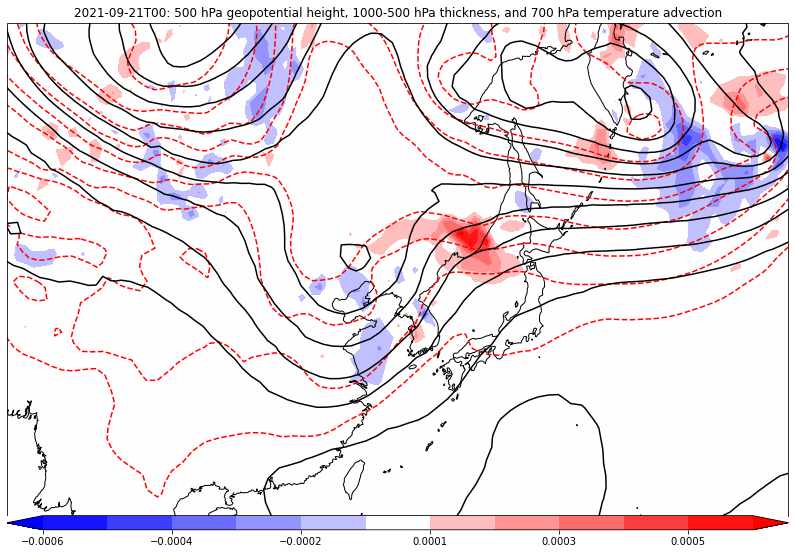

In [32]:
# Set up plot crs (mapcrs) and the data crs, will need to transform all variables
mapcrs = ccrs.LambertConformal(central_longitude=125, central_latitude=35,
                               standard_parallels=(30, 60))
datacrs = ccrs.PlateCarree()

fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)
ax.set_extent([90, 160, 20, 60], ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
cs1 = ax.contour(lons, lats, thick, transform=datacrs, levels=np.arange(4800,6000,60), colors='r', linestyles='dashed')
cs2 = ax.contour(lons, lats, z_500, transform=datacrs, levels=np.arange(4800,6000,60), colors='k', linestyles='solid')

#cs2 = ax.contour(lons, lats, zi_700, np.arange(2400,3300,60), colors='black', linestyles='solid', transform=datacrs)
clev_tadv=np.linspace(-0.0006,0.0006,13)
cf = ax.contourf(lons, lats, t_adv_700, cmap='bwr', levels=clev_tadv[clev_tadv!=0], transform=datacrs, extend='both')
cb = plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50)
ax.set_title(vtime + ' 500 hPa geopotential height, 1000-500 hPa thickness, and 700 hPa temperature advection')
plt.show()